In [1]:
import argparse
import concurrent.futures
import glob
import logging
import os
import random
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import yaml
from bokeh.models import HoverTool, BoxZoomTool, ResetTool, Range1d, UndoTool, WheelZoomTool, PanTool
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from hdbscan import HDBSCAN
from ogb.graphproppred import PygGraphPropPredDataset


from torch_geometric.data import DataLoader
from torch_geometric.transforms import Compose
from tqdm import tqdm


from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


from utils import better_to_nx
from unsupervised.embedding_evaluation_riku import GeneralEmbeddingEvaluation
from unsupervised.encoder import MoleculeEncoder
from unsupervised.learning import GInfoMinMax
from unsupervised.utils import initialize_edge_weight
from unsupervised.view_learner import ViewLearner
from datasets.loaders import get_val_loaders, get_val_datasets
from sklearn.metrics import pairwise_distances

/Users/zs18656/Documents/GitHub/general-gcl
/Users/zs18656/Documents/GitHub/general-gcl


In [2]:
def repair_config(args):
    key_names = list(args.keys())
    
    new_cfg = {}
    for key_name in key_names:
        try:
            new_cfg[key_name] = args[key_name]["value"]
        except:
            pass
    
    return new_cfg
def getSVD(X, s_only = True):
    # Assuming you have a dataset X with rows as instances and columns as features
    # Compute the mean of each feature
    mean = np.mean(X, axis=0)
    # Center the data
    X_centered = X - mean
    # Compute the covariance matrix
    covariance_matrix = np.cov(X_centered, rowvar=False)

    A = covariance_matrix
    U, s, VT = np.linalg.svd(A)
    if s_only:
        return s
    return U, s, VT

In [3]:
checkpoint = 'chem-100.pt'
# checkpoint = 'untrained'
# if checkpoint == "untrained":
#     checkpoint_path = "untrained"
    
checkpoint_path = f"outputs/{checkpoint}"
cfg_name = checkpoint.split('.')[0] + ".yaml"
config_path = f"outputs/{cfg_name}"
with open(config_path, 'r') as stream:
    args = yaml.safe_load(stream)
print(args)
args = repair_config(args)
print(args)
model = GInfoMinMax(MoleculeEncoder(emb_dim=args["emb_dim"], num_gc_layers=args["num_gc_layers"], drop_ratio=args["drop_ratio"], pooling_type=args["pooling_type"]),
                    proj_hidden_dim=args["emb_dim"])

{'wandb_version': 1, '_wandb': {'desc': None, 'value': {'cli_version': '0.13.4', 'framework': 'torch', 'is_jupyter_run': False, 'is_kaggle_kernel': False, 'python_version': '3.9.13', 'start_time': 1697703518.211216, 't': {1: [1, 5, 51, 53, 55, 77], 2: [1, 5, 51, 53, 55, 77], 3: [3, 13, 16, 23], 4: '3.9.13', 5: '0.13.4', 8: [5]}}}, 'batch_size': {'desc': None, 'value': 512}, 'dataset': {'desc': None, 'value': 'ogbg-molesol'}, 'drop_ratio': {'desc': None, 'value': 0.2}, 'emb_dim': {'desc': None, 'value': 300}, 'epochs': {'desc': None, 'value': 1024}, 'mlp_edge_model_dim': {'desc': None, 'value': 64}, 'model_lr': {'desc': None, 'value': 0.001}, 'no_molecules': {'desc': None, 'value': False}, 'no_socials': {'desc': None, 'value': True}, 'node_features': {'desc': None, 'value': False}, 'num_gc_layers': {'desc': None, 'value': 6}, 'pooling_type': {'desc': None, 'value': 'standard'}, 'reg_lambda': {'desc': None, 'value': 2.0}, 'seed': {'desc': None, 'value': 0}, 'view_lr': {'desc': None, 'val

In [4]:
if checkpoint != "untrained":
    model_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(model_dict['encoder_state_dict'])

In [5]:
my_transforms = Compose([initialize_edge_weight])
val_loaders, names = get_val_loaders(args["batch_size"], my_transforms)
val_datasets, names_datasets = get_val_datasets(my_transforms)

val_loaders = [val_loaders[0]] + val_loaders[5:]
val_datasets = [val_datasets[0]] + val_datasets[5:]
names = [names[0]] + names[5:]

Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molpcba/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molesol/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molclintox/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molfreesolv/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-mollipo/processed/val.pt


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


Processing twitch egos dataset
Entering ego processing loop


100%|███| 3083796/3083796 [00:01<00:00, 2610689.24it/s]
Processing...
Done!


Tree files exist


Processing...
Done!


Random files exist


Processing...
Done!


Facebook files exist


/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molpcba/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molesol/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molclintox/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molfreesolv/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-mollipo/processed/val.pt


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


Processing twitch egos dataset
Entering ego processing loop


100%|███| 3083796/3083796 [00:01<00:00, 1959569.55it/s]
Processing...
Done!


Tree files exist


Processing...
Done!


Random files exist


Processing...
Done!


Facebook files exist


In [6]:
print(names)

['ogbg-molpcba', 'facebook_large', 'twitch_egos', 'cora', 'roads', 'fruit_fly', 'trees', 'random', 'community']


## Scale embeddings <- todo


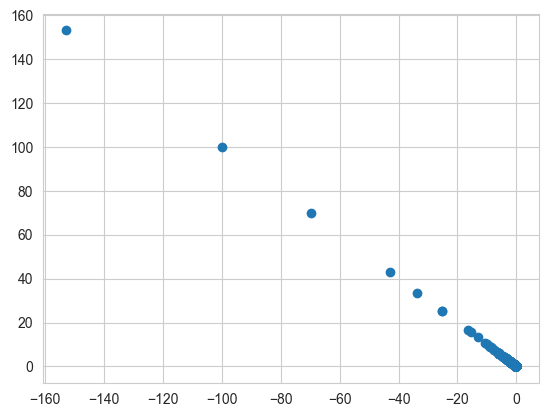

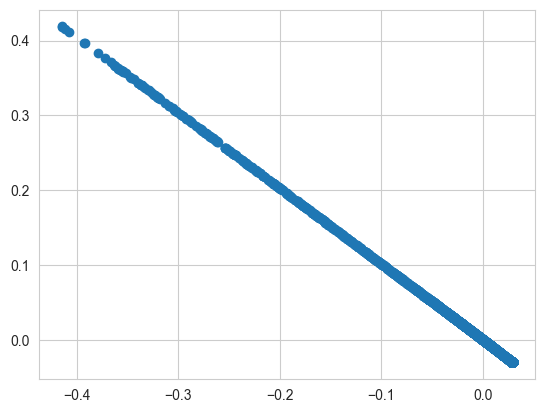

In [7]:
general_ee = GeneralEmbeddingEvaluation()
model.eval()
all_embeddings, separate_embeddings = general_ee.get_embeddings(model.encoder, val_loaders)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(all_embeddings)
separate_embeddings = [scaler.transform(emb) for emb in separate_embeddings]
all_embeddings = scaler.transform(all_embeddings)
plt.scatter(all_embeddings[:,0], all_embeddings[:,1])
plt.show()

# [(all_embeddings[:, i]).max() for i in range(300)]
bad_idxs = []
dimension_variance_threshold = 3
for idx, i in enumerate(all_embeddings[:]):
    if i.max() > dimension_variance_threshold:
        bad_idxs.append(idx)
# for idx in range(300):
#     print([idx for idx, i in enumerate(all_embeddings[:,idx]) if i > 3])
bad_idxs

all_embeddings2 = np.delete(all_embeddings, bad_idxs, axis=0)

cumsumidx = np.cumsum([0]+[len(x) for x in separate_embeddings])
separate_embeddings2 = []
for idx, i in enumerate(cumsumidx[:-1]):
    all_idxs = range(cumsumidx[idx], cumsumidx[idx + 1])
    all_idxs = [idx for idx in all_idxs if idx not in bad_idxs]
    separate_embeddings2.append(all_embeddings[all_idxs])

assert np.sum([len(x) for x in separate_embeddings2]) == len(all_embeddings2)
separate_embeddings = separate_embeddings2
all_embeddings = all_embeddings2

len(all_embeddings), [len(x) for x in separate_embeddings]

plt.scatter(all_embeddings[:,0], all_embeddings[:,1])
plt.show()

In [8]:
# save embeddings
# for idx, name in enumerate(names):
#     np.save('Saved_embeddings_01_11_2023/all_scaled_'+name+'.npy', separate_embeddings[idx])

# np.save('Saved_embeddings_01_11_2023/all_scaled.npy', all_embeddings)

In [9]:
N_per_dataset = [len(x) for x in separate_embeddings]

print(all_embeddings.shape)
print(len(separate_embeddings), N_per_dataset, np.sum([len(x) for x in separate_embeddings]))

(44690, 300)
9 [5000, 4734, 4990, 5000, 5000, 4966, 5000, 5000, 5000] 44690


## Centroid positioning and data SV-decomposition

In [10]:
dataset_centroid_means = np.array([x.mean(axis = 0) for x in separate_embeddings])

In [11]:
dataset_centroid_means.shape

(9, 300)

In [12]:
seperate_svds = [getSVD(x) for x in separate_embeddings]
true_label = []
for idx, i in enumerate(separate_embeddings):
    for j in i:
        true_label.append(idx)

In [13]:
names

['ogbg-molpcba',
 'facebook_large',
 'twitch_egos',
 'cora',
 'roads',
 'fruit_fly',
 'trees',
 'random',
 'community']

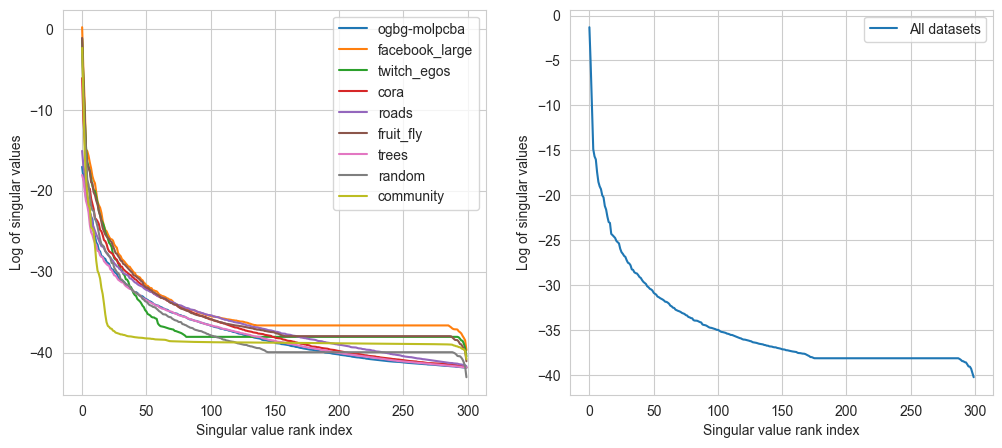

In [14]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,5))
for idx, s in enumerate(seperate_svds):
    s = np.log(s)
    ax[0].plot(s, label = names[idx])
#     plt.show()
all_svd = getSVD(all_embeddings)
logged_all_svd = np.log(all_svd)
ax[1].plot(logged_all_svd, label = 'All datasets')

for a in ax:
    a.set_xlabel('Singular value rank index')
    a.set_ylabel('Log of singular values')
    a.legend()

['ogbg-molpcba', 'facebook_large', 'twitch_egos', 'cora', 'roads', 'fruit_fly', 'trees', 'random', 'community']
0.2722309241441038
[[5000  971 1295 2086 5000 2036 5000 1780    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0 1604 1960 1846    0 1696    0 1604    0]
 [   0    6    9    8    0    9    0    7    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0  424  609  844    0  612    0  457    0]
 [   0  314  368  108    0  180    0  320    0]
 [   0 1415  749  108    0  433    0  832 5000]]
              precision    recall  f1-score   support

           0       1.00      0.22      0.36     23168
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.37      0.21      0.27      8710
           4       0.00      0.00      0.00        39
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00      2946
   

/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Log of Linear Model Basis Coefficient')

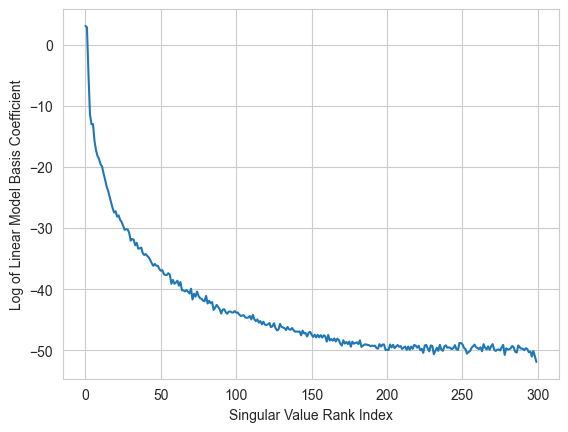

In [15]:
clf = LinearSVC(dual = False, C = 10 )

u, s, v = getSVD(all_embeddings, s_only=False)

# clf.fit(all_embeddings, true_label)

# Select a subset of left singular vectors (U) for dimensionality reduction
num_dimensions_to_retain = 300
U_reduced = u[:, :num_dimensions_to_retain]

# Transform the original dataset to the new basis, incorporating singular values
transformed_data = np.dot(all_embeddings, U_reduced) * s[:num_dimensions_to_retain]
clf.fit(transformed_data, true_label)

# pred = clf.predict(all_embeddings)
pred = clf.predict(transformed_data)

print(names)
print(accuracy_score(pred, true_label))
print(confusion_matrix(pred, true_label))
print(classification_report(pred, true_label))

x = abs(clf.coef_)
x = x.mean(axis = 0)
x = np.log(x)
plt.plot(x)

plt.xlabel('Singular Value Rank Index')
plt.ylabel('Log of Linear Model Basis Coefficient')


In [16]:
linear_seperation = []
for num_dimensions_to_retain in tqdm(range(1, 20)):
    clf = LinearSVC(dual = False, C = 10 )
    u, s, v = getSVD(all_embeddings, s_only=False)

    U_reduced = u[:, :num_dimensions_to_retain]
    # Transform the original dataset to the new basis, incorporating singular values
    transformed_data = np.dot(all_embeddings, U_reduced) * s[:num_dimensions_to_retain]
    clf.fit(transformed_data, true_label)
    
    pred = clf.predict(transformed_data)

    linear_seperation.append(accuracy_score(pred, true_label))


100%|██████████████████| 19/19 [00:12<00:00,  1.55it/s]


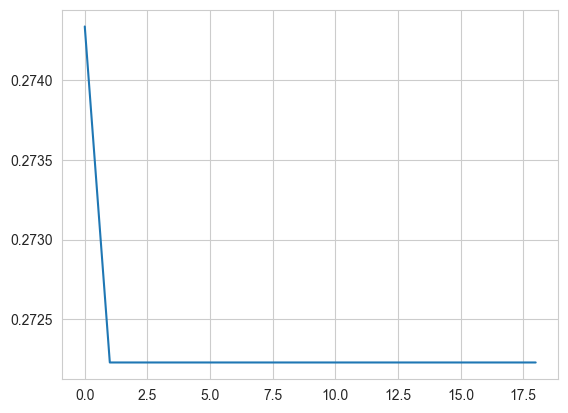

In [17]:
plt.plot(linear_seperation)

In [18]:
dataset_centroid_means = np.array([x.mean(axis = 0) for x in separate_embeddings])
dataset_centroid_medians = np.array([np.median(x,axis = 0) for x in separate_embeddings])

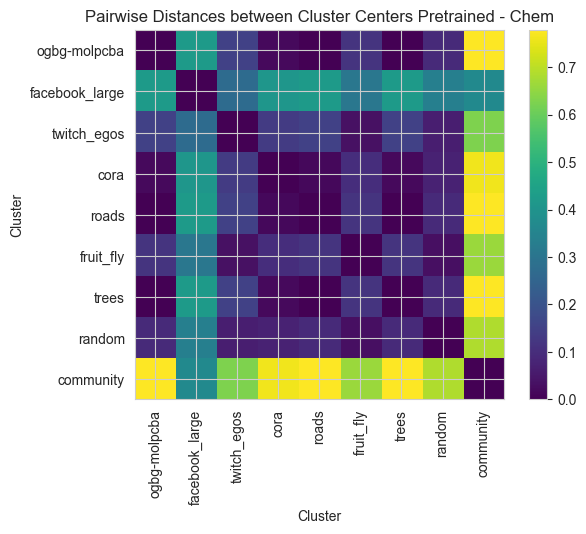

In [26]:
cluster_distances = pairwise_distances(dataset_centroid_means[:])
cluster_distances
plt.imshow(cluster_distances, cmap='viridis', origin='upper', interpolation='none')
plt.colorbar()
plt.xlabel('Cluster')
plt.ylabel('Cluster')
plt.title('Pairwise Distances between Cluster Centers Pretrained - Chem')
plt.xticks(range(len(names)), names, rotation = 90)
plt.yticks(range(len(names)), names, rotation = 0)

plt.savefig('Saved_embeddings_01_11_2023/pairwise_distances_chem.png', dpi = 300)

plt.show()

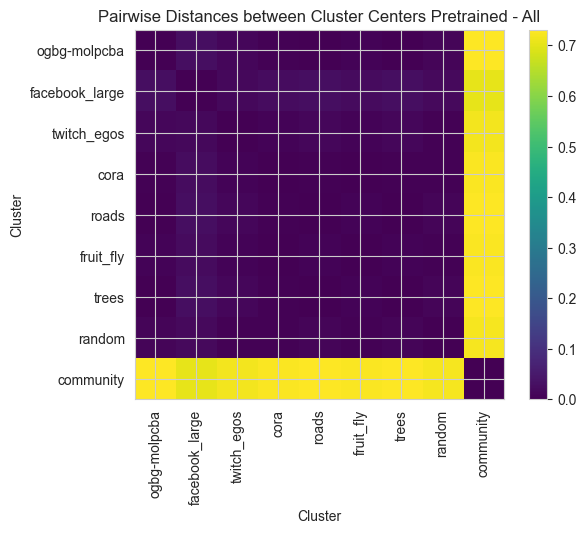

In [20]:
# cluster_distances = pairwise_distances(dataset_centroid_means[:])
cluster_distances = pairwise_distances(dataset_centroid_medians[:])

cluster_distances
plt.imshow(cluster_distances, cmap='viridis', origin='upper', interpolation='none')
plt.colorbar()
plt.xlabel('Cluster')
plt.ylabel('Cluster')
plt.title('Pairwise Distances between Cluster Centers Pretrained - All')
plt.xticks(range(len(names)), names, rotation = 90)
plt.yticks(range(len(names)), names, rotation = 0)
# plt.savefig('Saved_embeddings_01_11_2023/pairwise_distances_all.png', dpi = 300)

plt.show()

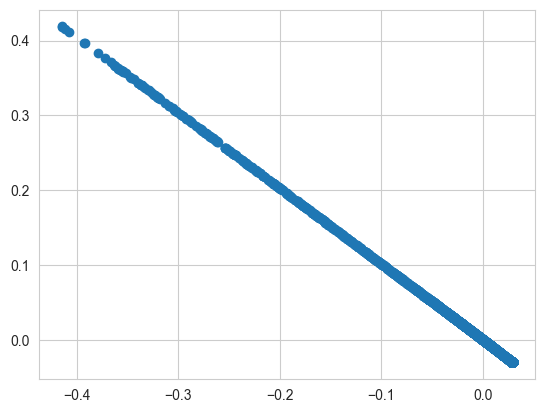

In [21]:
plt.scatter(all_embeddings[:,0], all_embeddings[:,1])

In [22]:
aa = [ np.linalg.norm(x) for x in all_embeddings]

In [24]:
min(aa), max(aa)

(0.18612666, 7.850095)